In [1]:
# Load relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from summarytools import dfSummary
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb 

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance

import pickle

In [2]:
# Always good to set a seed for reproducibility
SEED = 7
np.random.seed(SEED)

# 1. Load the Data 

In [3]:
# custom function to load and clean adult train data.
def cleandata(df):
    df = pd.read_csv(df, header= None)
    
    df.rename(columns = {0: "Age"}, inplace = True)
    df = df.Age.str.split(pat=',',expand=True)
    
    df.rename({0: "Age",
               1: "workclass",
               2: "fnlwgt",
               3: "education",
               4: "education_num",
               5: "marital_status",
               6: "occupation",
               7: "relationship",
               8: "race",
               9: "sex",
              10: "capital_gain",
              11: "capital_loss",
              12: "hours_per_week",
              13: "native_country",
              14: "label"}, axis = "columns", inplace = True)
    return df

# read our train adult data
data = cleandata("adult train.csv")
data.head()

,Age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  object
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  object
 3   education       32561 non-null  object
 4   education_num   32561 non-null  object
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  object
 11  capital_loss    32561 non-null  object
 12  hours_per_week  32561 non-null  object
 13  native_country  32561 non-null  object
 14  label           32561 non-null  object
dtypes: object(15)
memory usage: 3.7+ MB


From the info above, we realized that all columns have object as data type which is not correct. Next, we change columns to their relevant data types. This will help in computation of relevant metrics and also reduces memory usage.

In [6]:
# Change data types
numerical_col = ["Age","fnlwgt","education_num", "capital_gain", "capital_loss", "hours_per_week"]
for i in numerical_col:
    data[numerical_col] = data[numerical_col].astype(int)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int32 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int32 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int32 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int32 
 11  capital_loss    32561 non-null  int32 
 12  hours_per_week  32561 non-null  int32 
 13  native_country  32561 non-null  object
 14  label           32561 non-null  object
dtypes: int32(6), object(9)
memory usage: 3.0+ MB


Let's take look at our data in the most raw shape. I really recommend scatter plot because we can get the idea of our data without any manipulation

# 2. Exploratory Data Analysis

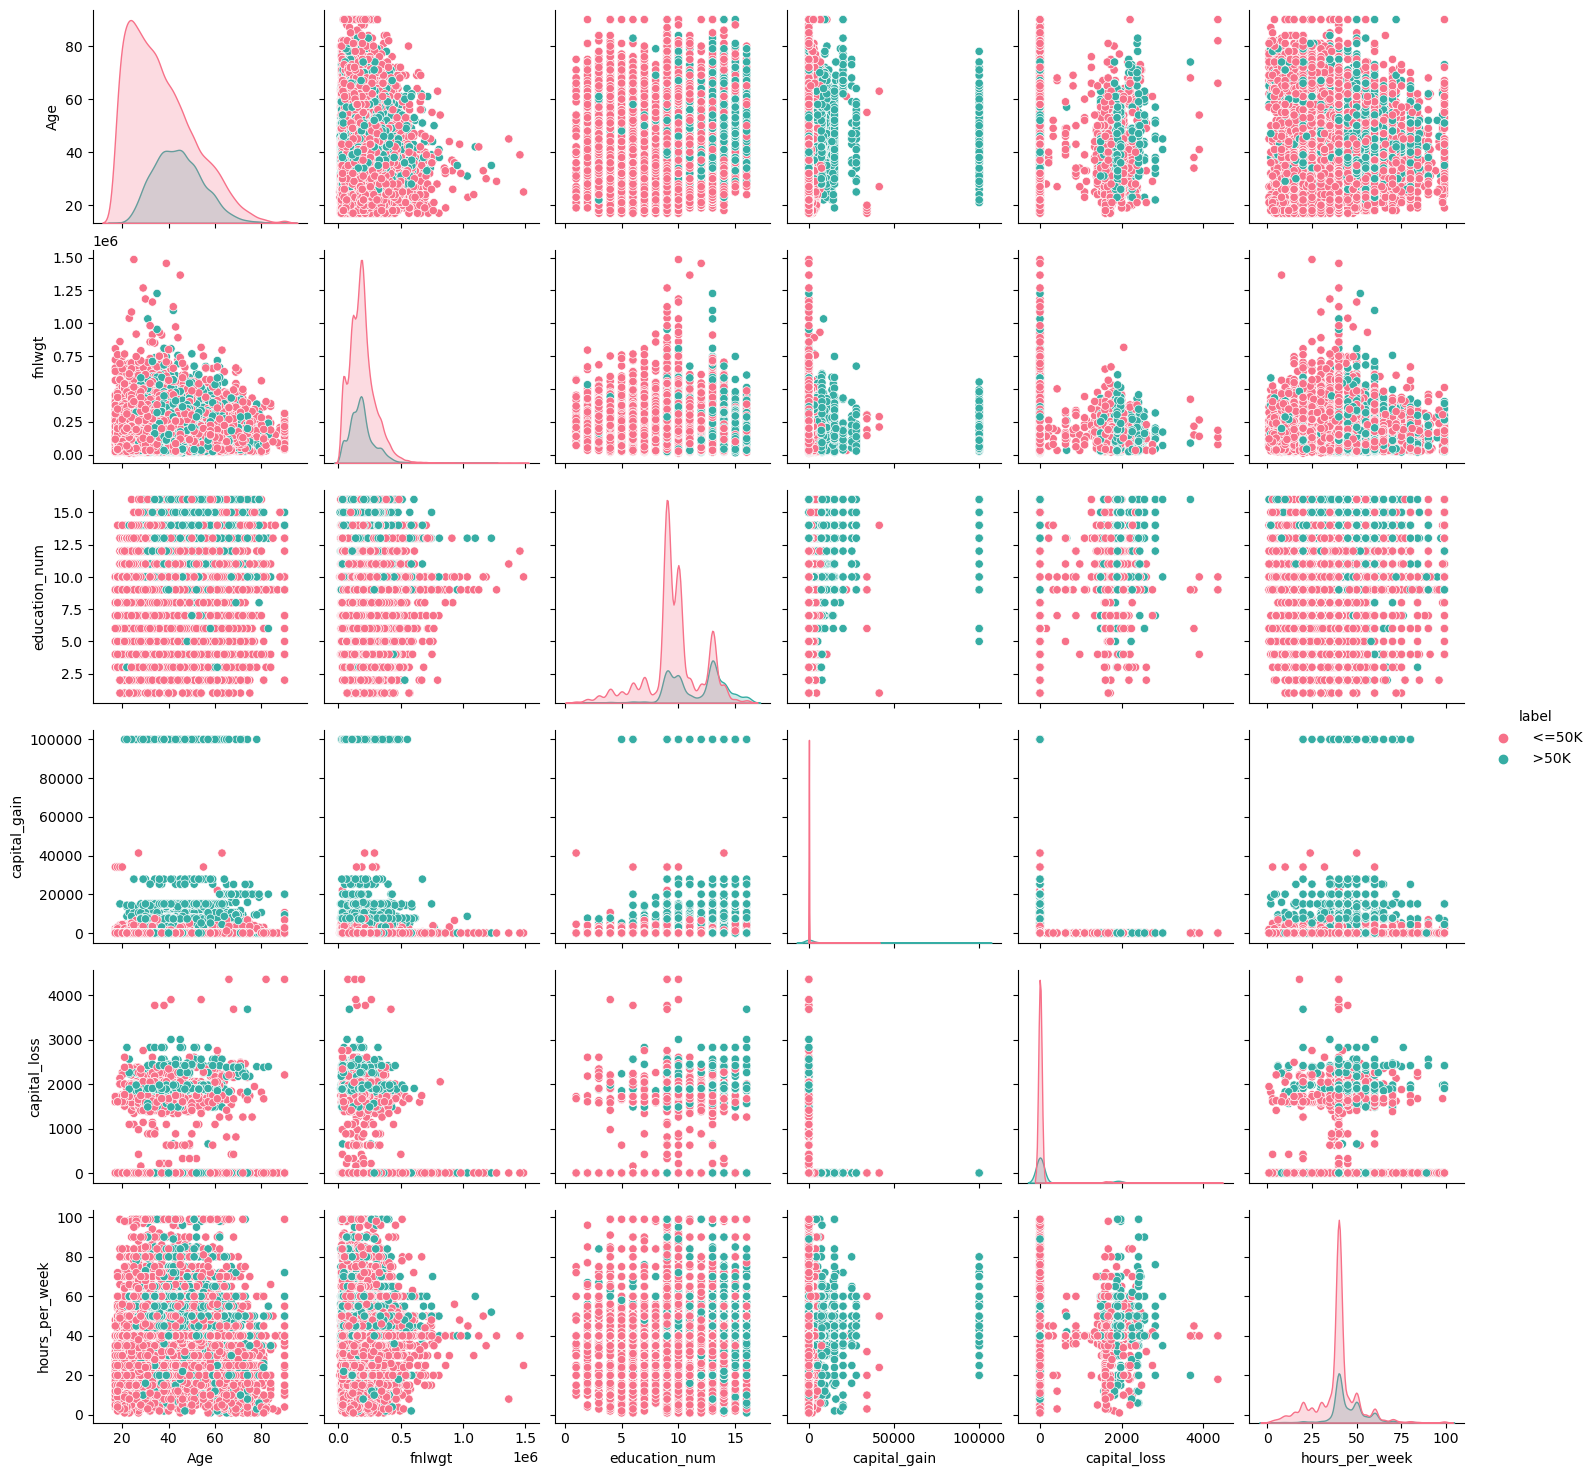

In [8]:
pairplot = sns.pairplot(data, hue="label", palette="husl")

Over 80+ years working above 60 hours per week? is it an outlier? Let's investigate further.

In [9]:
data_age_workhours = data[(data["Age"] > 80) & (data["hours_per_week"] > 50)]
data_age_workhours

,Age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,label
5370,90,Local-gov,227796,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,20051,0,60,United-States,>50K
7481,83,Private,195507,HS-grad,9,Widowed,Protective-serv,Not-in-family,White,Male,0,0,55,United-States,<=50K
7720,84,Private,241065,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,66,United-States,<=50K
8806,90,Private,87372,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,20051,0,72,United-States,>50K
11996,90,Private,40388,Bachelors,13,Never-married,Exec-managerial,Not-in-family,White,Male,0,0,55,United-States,<=50K
12830,81,Private,201398,Masters,14,Widowed,Prof-specialty,Unmarried,White,Male,0,0,60,?,<=50K
15356,90,Private,90523,HS-grad,9,Widowed,Transport-moving,Unmarried,White,Male,0,0,99,United-States,<=50K
24395,83,Self-emp-inc,153183,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,2392,55,United-States,>50K


In [10]:
dfSummary(data, is_collapsible = False)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Age[int32],Mean (sd) : 38.6 (13.6)min < med < max:17.0 < 37.0 < 90.0IQR (CV) : 20.0 (2.8),73 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8qNh9FAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACx0lEQVR4nO3cPW/aQBjA8edKCMeLbN4EGytDpA5IWVi6deyH7dotA0M3JL4BGxKvgobiOHSKVKkRwWe7+Dn9f/thD3/Zd5xtcz6fBSi6T7c+AeAad7c+gbwYY6oicp/iJ07n8/k5q/NBOl6Gaoypdjqdb0EQtFx/Y7fbrY0x34m1GAodaoqrYtBoNHrj8XgXhuEx6eDtdmsnk0lruVzeiwihFkCuoaa8/dp2u/01DMN60oFRFNk4jh8qlcpTr9f75Xj8quM45CC3UNPefqMosiLy8Pj4+LPb7e6SjJ3P563ZbFZ7eXkpuRwbxZPnFfU+CILWeDx+drn9vsVmrY2SXhXX6zVXQ8/kPkcNw/DocvslNvztw1DTLGheX1/LDuOAf1wMNc08821Bczwen0TEdUEDiMjHV1TneSYLGmTpqjmqyzyTOSayxF4/VCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUKFQr+FektxHJdFJDDGuAznmwAZI9R3HA6HchRFnweDQalUKiV+34tvAmSPUN9xOp3urLW10Wh07Pf76yRj+SZAPgj1gnq97vRiovBNgMyxmIIKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKrDXnwMeEcweoWaMRwTzQagZ4xHBfBBqTnhEMFsspqACoUIFQoUKhAoVCBUqECpUIFSowP+oBZNy+1XE0y1YQi2QtNuvIv5uwRJqgaTZfhXxewuWUAsoxfariKdbsCymoAKhQgVChQqEChUIFSoQKlQgVKhAqFCBP/w94+ur2oTqEZ9f1SZUj/j8qjahesj1WYE4jgMp6COGhAoRyeYRw81mszfG/BARl/EXI78q1O12a5Medb/fWxGRw+FgF4tF7X+O13rsW573arVqWGtrw+HQNJvN30mPvdlsGtPp9MtgMOjmMT/+A0VweEIjbO8LAAAAAElFTkSuQmCC"">",0(0.0%)
2,workclass[object],1. Private2. Self-emp-not-inc3. Local-gov4. ?5. State-gov6. Self-emp-inc7. Federal-gov8. Without-pay9. Never-worked,"22,696 (69.7%)2,541 (7.8%)2,093 (6.4%)1,836 (5.6%)1,298 (4.0%)1,116 (3.4%)960 (2.9%)14 (0.0%)7 (0.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAADPCAYAAADifqNtAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8qNh9FAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADg0lEQVR4nO3cTW7bVgBG0UfDSJuJBMOAl9DuwYvoYrsILaJ7MAxr0KSZqIMM4x9Koi6h5JwVPMBXJEjw83Q4HAYUbtY+AL8OsZERGxmxkREbGbGRERuZaYzxeYzxae2DMNu3w+HwZe1DnOL2/v7+r81mc7f2QZhnv98/T9P09zUGd7vZbO4eHx+/bLfbr2sfhve9vLz8vtvt7p6enj6NMa4vtjHG2G63Xx8eHv5d+zDM8nntA5zKAwIZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERuZ2zG+f7qy9kH42LX/nW73+/3zbre7G1f86cqvZL/fP48xvq19jlP4LPz6XO1n4ZP/9UHllCvb1f6yWNfRg5drHlywrqMGL9c+uGBdpwxePLVyEi91yYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBw1eLn2wQXrOnrwcs2DC9bls3AyBi9kPCCQOeY26vbJWWavq6yqONesdZVVFUs4Zl1lVcVZPCCQERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRmbWusqpiCbPXVVZVnMtn4WSsq8jMvbK5qnG2WYMXYxeW8OHgxdiFpcwdvBi7cDYvdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2Mh8OHgxdmEpswYvxi4swWfhZAxeyLx3ZXM1Y1FvDl6MXFjaq4MXIxcu4b3Bi5ELi/JSl4zYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyLy6rrKo4hLeXFdZVLE0GwQy1lVk3rqyuaqxuFfXVZZVXMIP6yrLKi7lrXWVZRWL81KXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzA+DF2MXLuXVwYuxC5fgs3AyBi9kXNnIGLyQMXghY/BCxktdMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjY11FxrqKjA0CGesqMh4QyNxM0/TnNE0eCri4mzHGH2OM39Y+CD8/t1EyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjI3Y4x/xhj/rX0Qfn42CGTcRsmIjYzBCxmDFzJuo2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGxrqKjHUVGbdRMmIjIzYyYiMjNjJiIyM2Mv8Ds4qD02JBrZQAAAAASUVORK5CYII="">",0(0.0%)
3,fnlwgt[int32],Mean (sd) : 189778.4 (105550.0)min < med < max:12285.0 < 178356.0 < 1484705.0IQR (CV) : 119224.0 (1.8),"21,648 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8qNh9FAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACUUlEQVR4nO3dMY7aQBiG4X/CQgxEBkQCHS1FpBSUHCKH3SOkcEvDDeiQDLKFYxZjnCapomSxDVl/5H36GaZ4ZWTPSOOKojCg6d699QKAazzdc3LnXNfMOjWmOBVFkd5qPdB1t1Cdc93xePzV9/1R1TniON47556JFfd8onZ83x8tl8t0MBgcyw6OosgLgmAUhmHHzAj1P3fXv34zs8FgcJxMJt8rDu/edDGQxcsUJBAqJBAqJBAqJBAqJBAqJLz6earG7pJ/uVzaFcYBv/lrqHV2l7Is8/I8/3w8Hr+ZWdXvqICZvf5Erby7tNlsRuv1unc+n1s11geY2ZU7U1V2l/b7PbtKuBlepiCBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCHhqut73kqe520z851zVYafiqJIb7wkvJHGhpokSTvLsi+z2azVarVKXcZmZhbH8d4590ysj6GxoZ5OpyfP83qLxeI4nU73Zc

From our checks above, our data consists of 32,561 rows and 15 columns. The data has no <b>missing values</b> but with 24 diplicated records.<br><br>
The mean age of participantrs is 39 with 73 distinct age values. In workclass column, 1,836 representing 5.6% have unknown values, 1,843 (5.7%) are unknown under occupation columns. 583 representing 1.8% have their native countries unknown.Our target column has two labels denoting binary classification problem.

In [11]:
# Replace '?' value in workclass, occupation and native-country columns.
lst = ['workclass', 'occupation', 'native_country']
data[lst] = data[lst].apply(lambda x: x.str.strip())
data[lst] = data[lst].replace('?', 'Unknown')

From workclass, occupation and native-country columns, we realized that we have '?' among the values. We replaced it with Unknown to make it easier for analysis.

In [13]:
# Check on duplicated records.
duplicated_data = data[data.duplicated()]
duplicated_data

,Age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,label
4881,25,Private,308144,Bachelors,13,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,Mexico,<=50K
5104,90,Private,52386,Some-college,10,Never-married,Other-service,Not-in-family,Asian-Pac-Islander,Male,0,0,35,United-States,<=50K
9171,21,Private,250051,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,10,United-States,<=50K
11631,20,Private,107658,Some-college,10,Never-married,Tech-support,Not-in-family,White,Female,0,0,10,United-States,<=50K
13084,25,Private,195994,1st-4th,2,Never-married,Priv-house-serv,Not-in-family,White,Female,0,0,40,Guatemala,<=50K
15059,21,Private,243368,Preschool,1,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,50,Mexico,<=50K
17040,46,Private,173243,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
18555,30,Private,144593,HS-grad,9,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,Unknown,<=50K
18698,19,Private,97261,HS-grad,9,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,40,United-States,<=50K
21318,19,Private,138153,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,10,United-States,<=50K


The duplicated values will not be taken out as it does not cause harm to our data and needed to conduct further analysis on the data.

## 2.1 Compare Labels to Age groups

In [14]:
# Initial step is to create an age group 
def CreateAgeGroup(row):
    
    if row["Age"] < 21:
        val = "16 - 20"
        
    elif row["Age"] < 31:
        val = "21 - 30"
        
    elif row["Age"] < 41:
        val = "31 - 40"
        
    elif row["Age"] < 51:
        val = "41 - 50"
        
    elif row["Age"] < 61:
        val = "51 - 60"    
    else:
        val = "60+"
        
    return val

data['age_group'] = data.apply(CreateAgeGroup, axis=1)
data.head()

,Age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,label,age_group
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,31 - 40
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,41 - 50
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,31 - 40
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,51 - 60
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,21 - 30


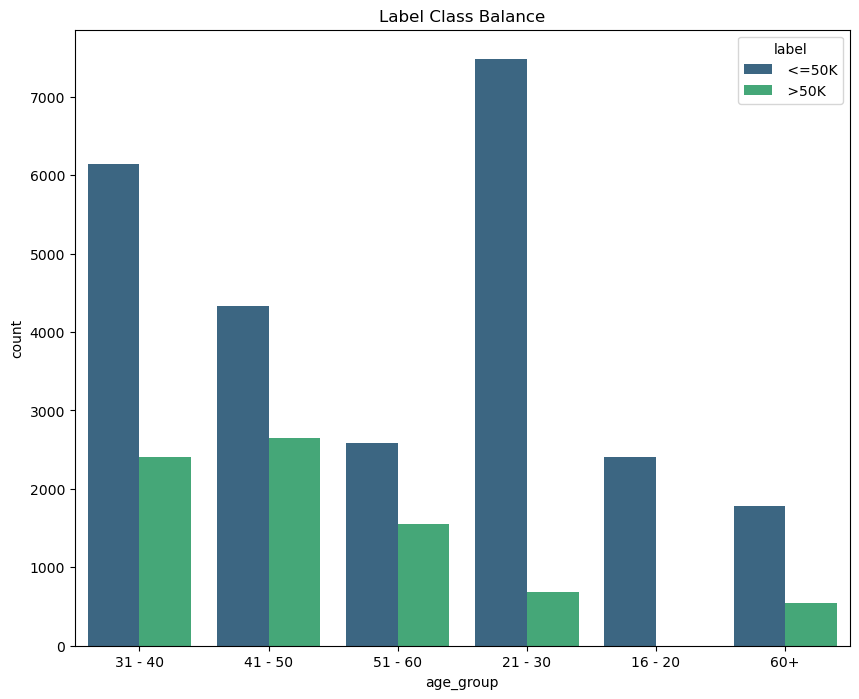

In [15]:
plt.figure(figsize=(10,8))
plt.title('Label Class Balance')
sns.countplot(x = "age_group", data = data, hue = "label", palette = "viridis")
plt.show()

The visual indicates that the age group of 41-50 has the highest number of individuals earning over 50k, with individuals in the age group of 31-40 following closely behind with about 2500 earners. Individuals in the age group of 16-20 do not earn more than 50k, while less than 500 individuals who are 60 years or older earn above 50k.<br><br> In contrast, over 7000 individuals in the age group of 21-30 earn up to or below 50k. When considering earners who make 50k or less, the age group of 31-40 comes in second place, followed by 41-50 and 51-60, respectively. People who are above 60 years of age earn the lowest income in this category.

## 2.2 Compare label to Gender

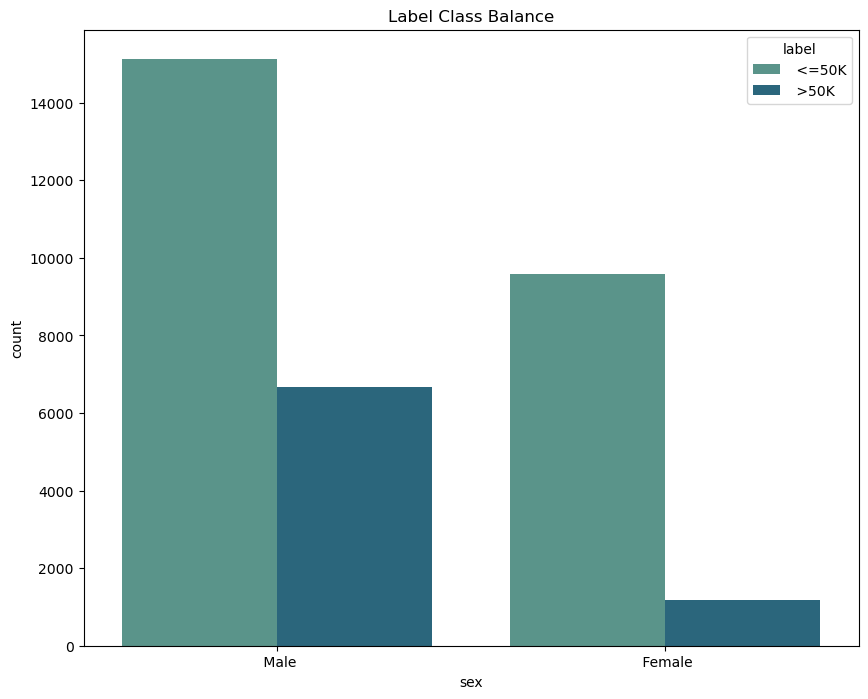

In [16]:
plt.figure(figsize=(10,8))
plt.title('Label Class Balance')
sns.countplot(x = "sex", data = data, hue = "label", palette = "crest")
plt.show()

The visual above compares income category to gender, revealing male dominance in all aspects of the category. Over 14,000 males earn up to 50K in income, compared to their female counterparts who have over 9,000 earners in this range.<br><br> Furthermore, the proportion of males who earn more than 50K in income is more than three times greater than that of females who earn above 50K.

## 2.3 Compare label to Occupation

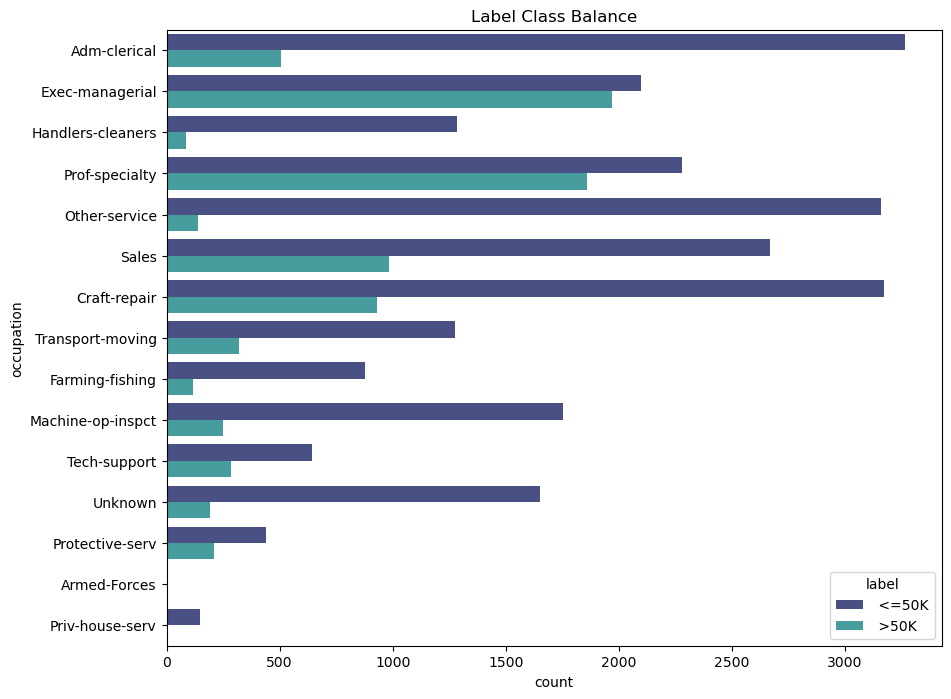

In [17]:
plt.figure(figsize=(10,8))
plt.title('Label Class Balance')
sns.countplot(y = "occupation", data = data, hue = "label", palette = "mako")
plt.show()

For income category less or equal to 50K, occupations like dm-clerical, Crat repairs and other services have the highest number surpassing 3000 individuals each. This is later followed by Sales and Prof Specialty.

On the contrary, for income holders of more than 50K, Executive Managerial occupation tops the chart with about 2000 individuals and followed by Prof Specialty. Armed forces occupation have zero individuals who earn above the 50K thresshold.

## 2.4 Check target distribution for class imbalance

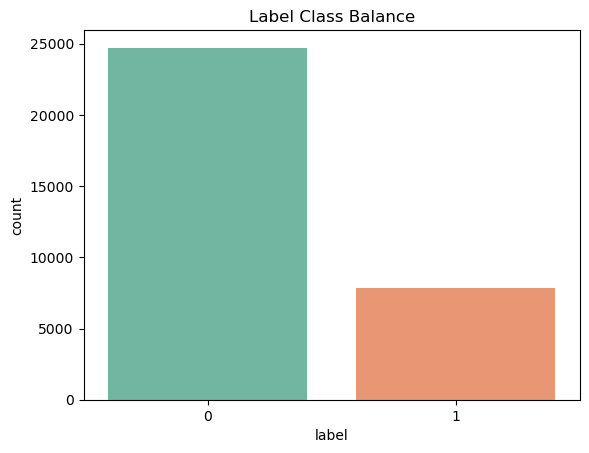

<Figure size 1000x800 with 0 Axes>

In [18]:
label_encoder = LabelEncoder()
data["label"] = label_encoder.fit_transform(data["label"])

plt.title('Label Class Balance')
sns.countplot(x = "label", data = data, palette = "Set2")
plt.figure(figsize=(10,8))
plt.show()

In the case of classification problem we always need to check the target distribution. If the distribution of target is not balanced, we must treat our data more carefully. For example we can use several methods to resample our data. We are not resampling the data in this tutorial. In addition, we need to use stratified method in our validation in order to keep the same distribution in our train and test data set.

# 3. Feature Processing

## 3.1 Split data into target and response variables

Our data needs to be splitted into training and evaluation data. For our training set set, we allocate 80 % of our data and 20% as our evaluation data. Prior to that, we drop our target column which is label in our X data and have y as our target column.

In [19]:
X = data.drop(["label"], axis = 1, inplace = False)
y = data.iloc[:,-2]

X_train, X_eval, y_train, y_eval = train_test_split(X, y, 
                                                  test_size = 0.2, 
                                                  random_state = 0)

In [37]:
y_train

15282    0
24870    0
18822    0
26404    0
7842     0
        ..
13123    1
19648    0
9845     0
10799    1
2732     0
Name: label, Length: 26048, dtype: int32

## 3.2 Column Transformation

In [21]:
# segregate categorical columns from numerical columns.
categorical_features = X.select_dtypes(include="object").columns
integer_features = X.select_dtypes(exclude="object").columns


# define the transformer for numeric columns
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# define the transformer for categorical columns
categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(drop="first", sparse=False, handle_unknown='ignore'))
        ])


features_preprocessor = ColumnTransformer(
    transformers=[
     ('numeric',      numeric_transformer,     integer_features),
     ('categorical', categorical_transformer, categorical_features),
    ])

# resample using SMOTE method
smote= SMOTE(sampling_strategy=1.0)

# 4. Train the Models

The idea here is to choose one simple model and use it as our baseline. For baseline, Logistic regrssion model was chosen and four other models were added.

## 4.1 Train baseline and other models

In [22]:
classifiers = [    
    LogisticRegression(),
    KNeighborsClassifier(),
    SVC(),
    DecisionTreeClassifier(),
    GaussianNB(),
]

# dataframe to store the accuracy of each classifier
df_results = pd.DataFrame(columns=
    ['Classifier', 'Accuracy','Precision', 'Recall', 'F1_Score'])


for classifier in classifiers:
    pipe = Pipeline(steps=[
        ('preprocessor', features_preprocessor),
        ('sampling', smote),
        ('classifier', classifier)])
    pipe.fit(X_train, y_train) 
    y_pred = pipe.predict(X_eval)
        
    # append the result to the dataframe
    df_results = df_results.append(pd.Series({
        'Classifier' : classifier, 
        'Accuracy' : accuracy_score(y_pred, y_eval),
        'Precision' : precision_score(y_pred, y_eval),
        'Recall':    recall_score(y_pred, y_eval),
        'F1_Score': f1_score(y_pred, y_eval)
    }),ignore_index = True)
df_results

,Classifier,Accuracy,Precision,Recall,F1_Score
0,LogisticRegression(),0.816367,0.849530,0.586326,0.693804
1,KNeighborsClassifier(),0.779057,0.794984,0.532773,0.637987
2,SVC(),0.820206,0.843260,0.593557,0.696711
3,DecisionTreeClassifier(),0.803163,0.643260,0.589994,0.615477
4,GaussianNB(),0.569937,0.934169,0.355948,0.515482


From the results above, using F1 score metric, our baseline model which is the logistic regression did a better job compared to the rest. Before we settle on this, let's investigate further with other models...

## 4.2 Investigate further on ensemble methods

The three main classes of ensemble learning methods are bagging, stacking, and boosting. Here, wwe will leverage Random Forest, ExtraTrees Classifier, Adaboost and Gradient boosting ensemble methods to investigate further and see if they out perform our baseline model.

In [23]:
classifiers_ensemble = [    
     RandomForestClassifier(),
     ExtraTreesClassifier(),
     AdaBoostClassifier(),
     GradientBoostingClassifier(),
     xgb.XGBClassifier() 
]

df_results1 = pd.DataFrame(columns=
    ['Classifier', 'Accuracy','Precision', 'Recall', 'F1_Score'])


for classifier in classifiers_ensemble:
    pipe = Pipeline(steps=[
        ('preprocessor', features_preprocessor),
        ('sampling', smote),
        ('classifier', classifier)])
    pipe.fit(X_train, y_train) 
    y_pred = pipe.predict(X_eval)
        
    # append the result to the dataframe
    df_results1 = df_results1.append(pd.Series({
        'Classifier' : classifier, 
        'Accuracy' : accuracy_score(y_pred, y_eval),
        'Precision' : precision_score(y_pred, y_eval),
        'Recall':    recall_score(y_pred, y_eval),
        'F1_Score': f1_score(y_pred, y_eval)
    }),ignore_index = True)
    
df_results1

,Classifier,Accuracy,Precision,Recall,F1_Score
0,"(DecisionTreeClassifier(max_features='auto', r...",0.846768,0.687147,0.687147,0.687147
1,"(ExtraTreeClassifier(random_state=910778376), ...",0.831414,0.640752,0.660633,0.650541
2,"(DecisionTreeClassifier(max_depth=1, random_st...",0.829418,0.807524,0.615679,0.698671
3,([DecisionTreeRegressor(criterion='friedman_ms...,0.834024,0.810031,0.624155,0.705048
4,"XGBClassifier(base_score=None, booster=None, c...",0.856134,0.726019,0.698432,0.711958


# 5. Feature Selection

Feature selection is also called variable selection or attribute selection. It is the automatic selection of attributes in your data (such as columns in tabular data) that are most relevant to the predictive modeling problem you are working on.

Feature selection methods aid you in your mission to create an accurate predictive model. They help you by choosing features that will give you as good or better accuracy whilst requiring less data.

Feature selection methods can be used to identify and remove unneeded, irrelevant and redundant attributes from data that do not contribute to the accuracy of a predictive model or may in fact decrease the accuracy of the model.

### 5.1 Correlation

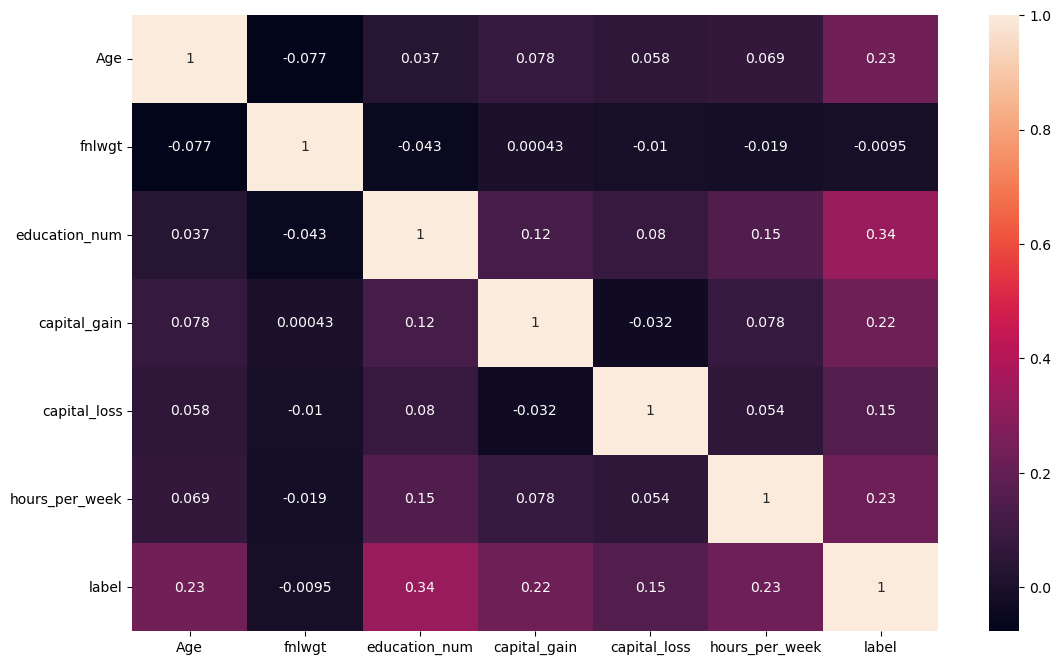

In [24]:
plt.rcParams["figure.figsize"] = (13, 8)
sns.heatmap(data.corr(),annot = True)
plt.show()

There aren't highly correlated features in this data.

### 5.2 Feature Importance

One of the simplest options to get a feeling for the "influence" of a given parameter in a linear classification model (logistic being one of those), is to consider the magnitude of its coefficient times the standard deviation of the corresponding parameter in the data. <br><br>Other techniques for finding feature importance or parameter influence exist (using p-values, bootstrap scores, various "discriminative indices", etc).Also, bagged decision trees like Random Forest and Extra Trees can be used to estimate the importance of features.<br><br>
On the other hand, we can use wrapper methods like SHAP, BORUTA etc.

Feature Importances :  [0.01271245 0.00279515 0.03581535 0.02328088 0.01275904 0.01476852
 0.0130893  0.         0.00913119 0.00373809 0.01500313 0.01458882
 0.00239703 0.0010934  0.00413754 0.         0.         0.
 0.00140914 0.00327014 0.00320457 0.00398642 0.00689162 0.01071475
 0.01406702 0.00463905 0.         0.00280215 0.004855   0.00498838
 0.37518257 0.00276187 0.00863761 0.00284954 0.00455397 0.
 0.0095811  0.02442577 0.01558557 0.01543267 0.01329895 0.04377536
 0.00164828 0.01712551 0.00675493 0.01317781 0.01632519 0.00950947
 0.00815886 0.01295733 0.0110836  0.02390337 0.00437812 0.0067595
 0.00356697 0.00255768 0.         0.02183745 0.01264847 0.00209798
 0.00055783 0.00182238 0.00313053 0.00112135 0.         0.
 0.0013113  0.00158471 0.00086332 0.00121099 0.00298289 0.
 0.         0.         0.         0.         0.00075167 0.
 0.         0.00246206 0.00220178 0.00339306 0.         0.00426012
 0.         0.         0.         0.00918075 0.         0.
 0.00167842 0.       

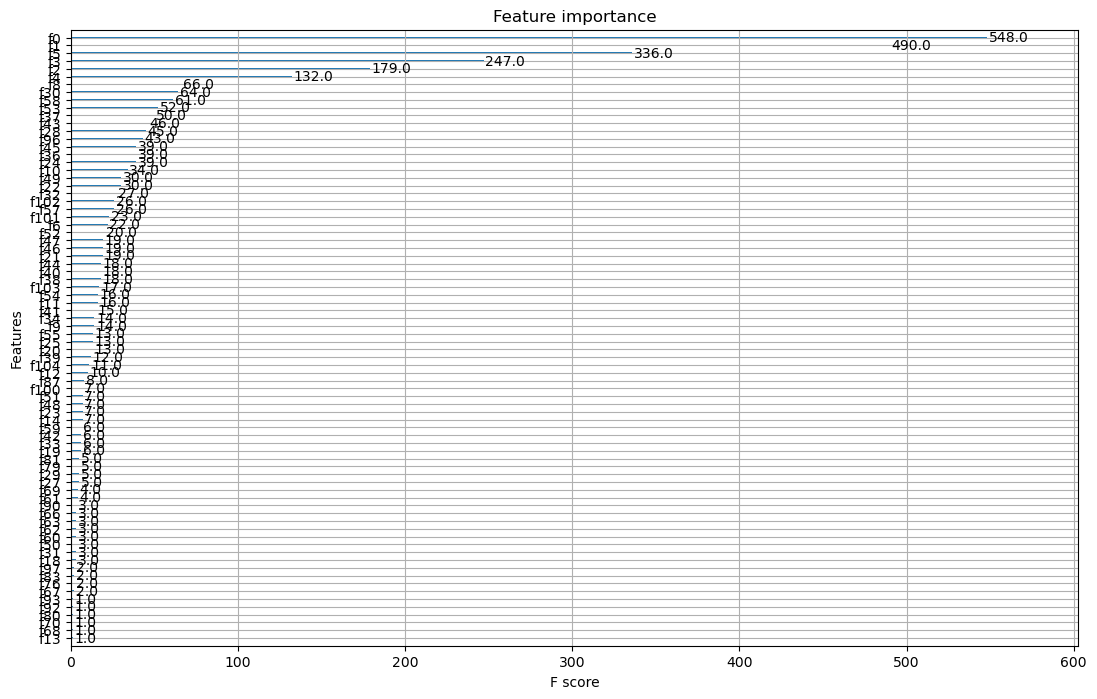

In [25]:
print("Feature Importances : ", classifiers_ensemble[4].feature_importances_)

# plot feature importance
plot_importance(classifiers_ensemble[4])
plt.show()

In [26]:
from sklearn.feature_selection import SelectFromModel
selection = SelectFromModel(classifiers_ensemble[4])

pipe_selection = Pipeline(steps=[
        ('preprocessor', features_preprocessor),
        ('sampling', smote),
        ('classifier', selection)]) 
pipe_selection.fit(X_train, y_train)

# Transform the train and test features
select_X_train = pipe_selection.transform(X_train)
select_X_Eval = pipe_selection.transform(X_eval)

# train model
classifiers_ensemble[4].fit(select_X_train, y_train)

y_pred_selection = classifiers_ensemble[4].predict(select_X_Eval)

print("Limited Features XGBoost Model Accuracy:", accuracy_score(y_eval, y_pred_selection))
print("Limited Features XGBoost Model F1 Score:", f1_score(y_eval , y_pred_selection))

Limited Features XGBoost Model Accuracy: 0.865806847842776
Limited Features XGBoost Model F1 Score: 0.7073007367716009


# 6. Hyperparameter Tuning 

In [27]:
param_grid = { 
    "classifier__colsample_bytree": [ 0.3, 0.5 , 0.8 ],
    "classifier__reg_alpha": [0, 0.5, 1, 5],
    "classifier__reg_lambda": [0, 0.5, 1, 5]
    }
# Set up score
scoring = ['f1']

grid_search_pipe = Pipeline(steps=[
        ('preprocessor', features_preprocessor),
        ('sampling', smote),
        ('classifier', classifiers_ensemble[4])]) 
# Define grid search
grid_search = GridSearchCV(estimator=grid_search_pipe, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           refit='f1', 
                           n_jobs=-1, 
                           cv=None, 
                           verbose=0)
# Fit grid search
grid_result = grid_search.fit(X_train,y_train)
print(f'The best hyperparameters are {grid_result.best_params_}')

The best hyperparameters are {'classifier__colsample_bytree': 0.3, 'classifier__reg_alpha': 0.5, 'classifier__reg_lambda': 0.5}


In [28]:
model = xgb.XGBClassifier(colsample_bytree = 0.3, 
                          reg_alpha = 0.5, reg_lambda = 1) 
hyper_pipe = Pipeline(steps=[
        ('preprocessor', features_preprocessor),
        ('sampling', smote),
        ('classifier', model)]) 
model = hyper_pipe .fit(X_train, y_train)
model1 = model.predict(X_eval)
f1 = f1_score(y_eval, model1)
print(f'The f1 score is {f1}')

The f1 score is 0.7241063244729605


In [36]:
model1

array([0, 0, 0, ..., 1, 0, 1])

# Exportation

In [29]:
to_export = {
    "data": data,
    "pipeline": hyper_pipe
}

with open('ml_pipeline.pkl', 'wb') as file:
    pickle.dump(to_export, file)

In [35]:
data

,Age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,label,age_group
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,31 - 40
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,41 - 50
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0,31 - 40
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0,51 - 60
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,21 - 30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0,21 - 30
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1,31 - 40
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0,51 - 60
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0,21 - 30


In [ ]:
data["workclass"].value_counts()

In [30]:
import sklearn; print("Scikit-Learn", sklearn.__version__)

Scikit-Learn 1.0.2
